In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as utils

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True,
                                      transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                 ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def plot_images(images, ncol=12, figsize=(8,8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    grid = utils.make_grid(images, nrow=ncol, padding=0, normalize=False).cpu()
    ax.imshow(grid[0], cmap='gray')

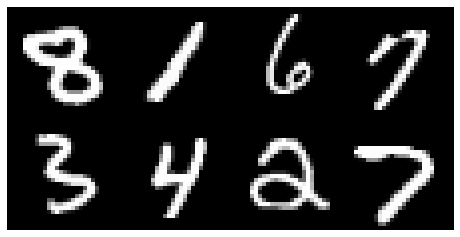

In [ ]:
# выведем картинки из датасета MNIST
images, labels = iter(trainloader).next()
plot_images(images[:8], ncol=4)

In [ ]:
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, blind_center=False):
        super(MaskedConv2d, self).__init__()
        self.in_ch = in_channels    # число входных каналов
        self.out_ch = out_channels  # число выходных каналов
        self.ker_s = kernel_size    # размер ядра свертки (как в Conv2d)
        self.bc = blind_center      # флаг с информацией о том, заполнен ли центр ядра нулем
        self.pad = int((self.ker_s - 1)/2)
        self.layer = nn.Conv2d(in_channels=self.in_ch, out_channels=self.out_ch, 
                               kernel_size=self.ker_s, padding=self.pad, bias=False)   
        
        self.register_buffer('mask', self.layer.weight.data.clone()) # если мы хотим добавить в модель веса
                                                                     # которые будут сохраняться при save(state_dict)
                                                                     # но не должны обновляться при использовании оптимизатора
                                                                     # то используем при инициализации модели self.register_buffer
        self.mask.fill_(1)
        _, depth, height, width = self.layer.weight.size()
        
        if self.bc == True: 
            self.mask[:,:,height//2,width//2:] = 0
            self.mask[:,:,height//2+1:,:] = 0
        else:
            self.mask[:,:,height//2,width//2+1:] = 0
            self.mask[:,:,height//2+1:,:] = 0
        
    def forward(self, x):
        self.layer.weight.data *= self.mask
        y = self.layer(x)
        return y

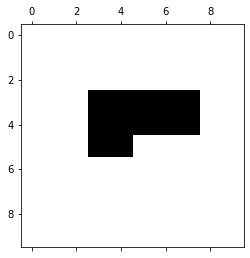

In [ ]:
# нарисуем receptive field одного нейрона c маскированнsм сверточным слоем

def get_binary_receptive_field(net, image_size, i, j):
    inputs = torch.randn(32, 1, image_size[0], image_size[1], requires_grad=True)
    net.eval()
    net.to('cpu')
    outputs = net(inputs)
    loss = outputs[0,0,i,j]
    loss.backward()
    rfield = torch.abs(inputs.grad[0, 0]) > 0  # вернем только те пиксели, у которых изменился градиент
    return rfield

layer = MaskedConv2d(in_channels=1, out_channels=2, kernel_size=5, blind_center=True)

rfield = get_binary_receptive_field(layer, image_size=(10, 10), i=5, j=5)
plt.matshow(rfield, cmap='gray_r')

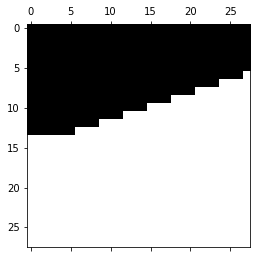

In [ ]:
# нарисуем receptive field нескольких застаканных слоев
masked_list = []
net = nn.Sequential(
    MaskedConv2d(in_channels=1, out_channels=2, kernel_size=5, blind_center=True),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=True),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=True),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=True),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=True),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=True),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=True),
    MaskedConv2d(in_channels=2, out_channels=2, kernel_size=5, blind_center=True),
    nn.Conv2d(2, 256, 1)
)

rfield = get_binary_receptive_field(net, image_size=(28, 28), i=13, j=13)
plt.matshow(rfield, cmap='gray_r', clim=[0, 1])

# посмотрите как много контекста мы потеряли, поставив на каждом из слоев blind_center=True
# измените параметр blind_center и вновь визуализируйте receptive field

Мы хотим учитывать только контекст предыдущих пикселей (исключая текущий), но при этом не терять часть контекста до рассматриваемого пикселя (как оно случилось в предыдущей ячейке). Поэтому при моделировании сети необходимо поставить blind_center=True только для первого слоя MaskerConv2d (для остальных поставить False).

In [ ]:
# определим класс модели PixelCNN
class PixelCNN(nn.Module):
    def __init__(self, n_channels=64, kernel_size=7):
        super(PixelCNN, self).__init__()
        self.n_ch = n_channels
        self.k_sz = kernel_size
        self.pixel_cnn = nn.Sequential(
        MaskedConv2d(in_channels=1, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=True),
        nn.BatchNorm2d(self.n_ch),
        nn.ReLU(),
        MaskedConv2d(in_channels=self.n_ch, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=False),
        nn.BatchNorm2d(self.n_ch),
        nn.ReLU(),
        MaskedConv2d(in_channels=self.n_ch, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=False),
        nn.BatchNorm2d(self.n_ch),
        nn.ReLU(),
        MaskedConv2d(in_channels=self.n_ch, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=False),
        nn.BatchNorm2d(self.n_ch),
        nn.ReLU(),
        MaskedConv2d(in_channels=self.n_ch, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=False),
        nn.BatchNorm2d(self.n_ch),
        nn.ReLU(),
        MaskedConv2d(in_channels=self.n_ch, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=False),
        nn.BatchNorm2d(self.n_ch),
        nn.ReLU(),
        MaskedConv2d(in_channels=self.n_ch, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=False),
        nn.BatchNorm2d(self.n_ch),
        nn.ReLU(),
        MaskedConv2d(in_channels=self.n_ch, out_channels=self.n_ch, kernel_size=self.k_sz, blind_center=False),
        nn.BatchNorm2d(self.n_ch),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.n_ch, out_channels=256, kernel_size=1)
        )

    def forward(self, x):
        res = self.pixel_cnn(x)
        return res

Очень важный момент - картинки в датасете MNIST хранятся в формате чисел float из [0,1] - т.е. цвет пикселя может быть любым числом от 0 (черный) до 1 (белый). При этом наша PixelCNN возвращает числа int от 0 до 255 (нулю также соответствует черный, 255 - белый). Поэтому для подсчета лосса исходную картинку необходимо нормировать - для этого я написала отдельную функцию.

In [ ]:
def loss_fn(logits, x):
    """
    считает лосс для модели PixelCNN
    аргументы:
    logits: предсказания (выход) модели - число от 0 до 255
    x: батч изображений (со значениями от 0 до 1)
    """
    batch_size = logits.shape[0]
    loss = nn.CrossEntropyLoss()
    logits = logits.view(batch_size, 256, -1)
    x = x.view(batch_size, -1)
    x = ((255*x)/1).long()
    
    return loss(logits, x)

In [ ]:
def generate(net, n_samples, image_size=(28, 28), device=device):
    """
    генерирует картинки с помощью ранее инициализированной/обученной сети
    аргументы:
    net: сеть, которая должна сгенерить картинки
    n_samples: количество сгенерированных картинок
    image_size: размер картинки
    """
    net.eval()
    samples = torch.zeros(n_samples, 1, image_size[0], image_size[1]).to(device)
    
    for i in range(image_size[0]):  # для каждого пикселя возвращается массив "вероятностей" того, что он имеет тот или иной цвет
                                    # т.е. для каждого пикселя каждой картинки из батча возвращается массив размера 256 (для каждого числа от 0 до 255 - вероятность)
        for j in range(image_size[1]): 
            output = net(samples)
            prob = F.softmax(output[:, :, i, j], dim=1).data # софтмакс нормирует массив "вероятностей" чтобы они действительно стали вероятностями
                                                             # т.е. давали в сумме 1
            
            pixel = torch.multinomial(prob, 1).float() / 255. 
            samples[:, :, i, j] = pixel
    
    return samples

In [ ]:
# создаем модель
net = PixelCNN(n_channels=64, kernel_size=7)
net.to(device)

PixelCNN(
  (pixel_cnn): Sequential(
    (0): MaskedConv2d(
      (layer): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaskedConv2d(
      (layer): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaskedConv2d(
      (layer): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaskedConv2d(
      (layer): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaskedConv2d(
      (layer): Conv2d(64, 64, 

Ниже приведен метод для отрисовки сгенерированных семплов (первый аргумент - массив из картинок, второй - количество столбцов для отрисовки)

In [ ]:
def plot_generated_samples(samples, ncol=12):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis('off')
    ax.imshow(
        np.transpose(
            utils.make_grid(samples, nrow=ncol, padding=0, normalize=True).to('cpu'),
            (1,2,0)
        )
     )

In [ ]:
samples = generate(net, n_samples=120, device=device)
plot_generated_samples(samples, ncol=10)

torch.Size([120, 1, 28, 28])
torch.Size([120, 256, 28, 28])
torch.Size([120, 1, 28, 28])


KeyboardInterrupt: ignored

In [ ]:
epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(epochs): 
    losses = []
    for images, targets in trainloader: 
        images = images.to(device)
        logits = net.forward(images)
        
        targets = images
        print(targets.shape)
        
        batch_loss = loss_fn(logits, targets)
        losses.append(float(batch_loss.data))
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    print(f' Epoch {epoch+1} | Average loss {np.mean(losses)}')

 Epoch 1 | Average loss 0.9268759428342184
 Epoch 2 | Average loss 0.7941170915921529
 Epoch 3 | Average loss 0.7798463381767273
 Epoch 4 | Average loss 0.7713005221048991
 Epoch 5 | Average loss 0.7652707059224446
 Epoch 6 | Average loss 0.7533404436429342
 Epoch 7 | Average loss 0.7462120148658753
 Epoch 8 | Average loss 0.7418757294336955
 Epoch 9 | Average loss 0.7372078264872233
 Epoch 10 | Average loss 0.7327679268519084


In [ ]:
# генерируем картинки обученной моделью
with torch.no_grad():
    samples = generate(net, n_samples=120, device=device)
    plot_generated_samples(samples)